In [1]:
from dask.distributed import Client

# Inicia un cliente de Dask con un clúster local y habilita el dashboard
client = Client()

# Imprime información sobre el cliente y el dashboard
print("Dashboard disponible en:", client.dashboard_link)

Dashboard disponible en: http://127.0.0.1:8787/status


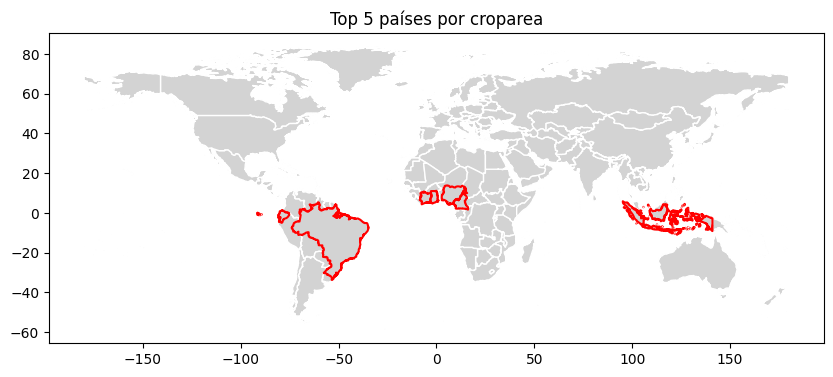

In [1]:

import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np

# 1. Leer el dataset de cacao
cocoa_ds = xr.open_dataset("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/yields_data/CROPGRIDSv1.08_cocoa.nc")
cocoa = cocoa_ds["croparea"]

lat_vals = cocoa_ds["lat"].values
lon_vals = cocoa_ds["lon"].values

# Crear grilla 2D de lat, lon
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)
crop_vals = cocoa.values

# Aplanar la grilla para convertirla en columnas
lat_flat = lat2d.ravel()
lon_flat = lon2d.ravel()
crop_flat = crop_vals.ravel()

df = pd.DataFrame({
    "lat": lat_flat,
    "lon": lon_flat,
    "croparea": crop_flat
})

# 2. Filtrar celdas con croparea > 0
df = df[df["croparea"] > 0]

# 3. Convertir a GeoDataFrame de puntos
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

# 4. Leer el shapefile y asegurar CRS
provincias = gpd.read_file("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs/shapefile/world-administrative-boundaries.shp")
provincias = provincias.to_crs("EPSG:4326")

# 5. Hacer join espacial para asignar cada punto a su país/provincia
join_gdf = gpd.sjoin(provincias, gdf_points, how="inner", predicate="intersects")

# 6. Agrupar por la columna que identifica el país
#    Ajusta según tu shapefile (ej. "iso3", "COUNTRY", "NAME", etc.)
country_col = "iso3"  # <= cambia si necesitas otra columna
sum_crop = (
    join_gdf.groupby(country_col)["croparea"]
    .sum()
    .reset_index(name="sum_croparea")
)

# 7. Ordenar de mayor a menor y extraer los top 5
sum_crop = sum_crop.sort_values("sum_croparea", ascending=False)
top5_countries = sum_crop.head(7)[country_col].unique()

# 8. Filtrar el shapefile para quedarse solo con esos 5 países
provincias_top5 = provincias[provincias[country_col].isin(top5_countries)]

# (Opcional) plotear para verificar
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
provincias.plot(ax=ax, facecolor="lightgray", edgecolor="white")  # Todos los países (en gris)
provincias_top5.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.5)  # Top 5 (en rojo)
ax.set_title("Top 5 países por croparea")
plt.show()

# provincias_top5 es tu shapefile reducido a los 5 países con mayor croparea

In [3]:
pcco_usdm = pd.read_csv("/Users/charly_1/Downloads/PCOCOUSDM.csv")
pcco_usdm.head()

,observation_date,PCOCOUSDM
0,1990-01-01,995.0
1,1990-02-01,1022.0
2,1990-03-01,1131.0
3,1990-04-01,1336.0
4,1990-05-01,1443.0


<Axes: >

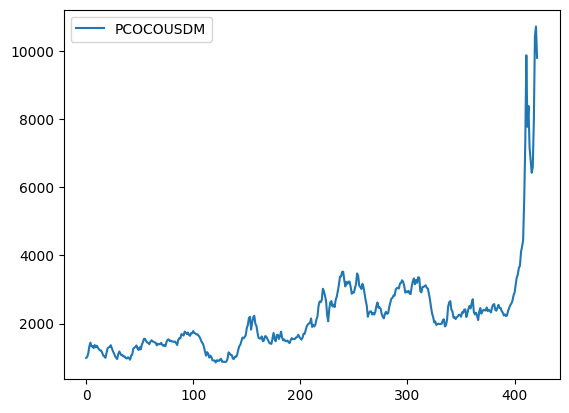

In [5]:
pcco_usdm.plot()